In [1]:
import os
import scipy
import logging
import tempfile
import numpy as np
import nibabel as nib
import multiprocessing
from dipy.data import get_sphere
from dipy.io import read_bvals_bvecs
from joblib import Parallel, delayed
from dipy.core.sphere import Sphere
from dipy.reconst.shm import sf_to_sh
from dipy.core.gradients import gradient_table_from_bvals_bvecs
from scilpy.reconst.multi_processes import fit_from_model, convert_sh_basis
from scilpy.reconst.raw_signal import compute_sh_coefficients
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.shm import real_sh_descoteaux_from_index, sh_to_sf
from scilpy.utils.bvec_bval_tools import (DEFAULT_B0_THRESHOLD,
                                          check_b0_threshold, identify_shells,
                                          is_normalized_bvecs, normalize_bvecs)

/home/local/VANDERBILT/kanakap/py38-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/dwi_fodf.nii.gz').get_fdata()
vol = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/2000dwi_fodf.nii.gz')
og_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/bvec_fodf.bvec'
ob_file = '/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/bval_fodf.bval'
vec_folder = '/home/local/VANDERBILT/kanakap/try_fx_emp/bvec'
val_folder = '/home/local/VANDERBILT/kanakap/try_fx_emp/bval'
mask = nib.load('/nfs/masi/kanakap/projects/LR_tract/MASiVar_kids/sub-cIVs001/ses-s1Bx2/prequal_dwi_cat/mask.nii.gz').get_fdata()

val, vec = read_bvals_bvecs(ob_file,og_file)

bvec_vols = []
for i in sorted(os.listdir(vec_folder)):
    if i.endswith('.nii.gz'):
        bvec_vol = nib.load(vec_folder + '/' + i).get_fdata()
        bvec_vol = np.expand_dims(bvec_vol,4)
        bvec_vol = np.transpose(bvec_vol,(0,1,2,4,3))
        bvec_vols.append(bvec_vol)
bvec_stack = np.stack(bvec_vols,3)
bvec_stack = bvec_stack.squeeze()

bval_vols = []
for i in sorted(os.listdir(val_folder)):
    if i.endswith('.nii.gz'):
        bval_vol = nib.load(val_folder + '/' + i).get_fdata()
        bval_vols.append(bval_vol)
bval_stack = np.stack(bval_vols,3)

In [3]:
def compute_dwi_attenuation(dwi_weights: np.ndarray, b0: np.ndarray):
    """ Compute signal attenuation by dividing the dwi signal with the b0.
    Parameters:
    -----------
    dwi_weights : np.ndarray of shape (X, Y, Z, #gradients)
        Diffusion weighted images.
    b0 : np.ndarray of shape (X, Y, Z)
        B0 image.
    Returns
    -------
    dwi_attenuation : np.ndarray
        Signal attenuation (Diffusion weights normalized by the B0).
    """
    b0 = b0[..., None]  # Easier to work if it is a 4D array.

    # Make sure that, in every voxels, weights are lower in the b0. Should
    # always be the case, but with the noise we never know!
    erroneous_voxels = np.any(dwi_weights > b0, axis=3)
    nb_erroneous_voxels = np.sum(erroneous_voxels)
    if nb_erroneous_voxels != 0:
        logging.info("# of voxels where `dwi_signal > b0` in any direction: "
                     "{}".format(nb_erroneous_voxels))
        dwi_weights = np.minimum(dwi_weights, b0)

    # Compute attenuation
    dwi_attenuation = dwi_weights / b0

    # Make sure we didn't divide by 0.
    dwi_attenuation[np.logical_not(np.isfinite(dwi_attenuation))] = 0.

    return dwi_attenuation

In [13]:
# DWI TO SF
def reconstruct_signal_at_voxel(i,j,k,mask,n,bvec_stack,bval_stack,dwi_hat):
    if mask[i,j,k] == 1:
        dwi = n[i][j][k]
        vec = bvec_stack[i,j,k,:,:]
        val = bval_stack[i,j,k,:]
        gradient_table = gradient_table_from_bvals_bvecs(val, vec)
        sh_order=10
        basis_type='descoteaux07'
        smooth=0.00
        use_attenuation=True
        force_b0_threshold=False
        mask=None
        sphere=None
        # Extracting infos
        b0_mask = gradient_table.b0s_mask
        bvecs = gradient_table.bvecs
        bvals = gradient_table.bvals
        dwi = np.reshape(dwi,[1,1,1,bvals.shape[0]])

        if not is_normalized_bvecs(bvecs):
                logging.warning("Your b-vectors do not seem normalized...")
                bvecs = normalize_bvecs(bvecs)

        b0_threshold = check_b0_threshold(force_b0_threshold, bvals.min())

        # Ensure that this is on a single shell.
        shell_values, _ = identify_shells(bvals)
        shell_values.sort()
        # if shell_values.shape[0] != 2 or shell_values[0] > b0_threshold:
        #     raise ValueError("Can only work on single shell signals.")


        # Keeping b0-based infos
        bvecs = bvecs[np.logical_not(b0_mask)]
        weights = dwi[..., np.logical_not(b0_mask)]

        # Compute attenuation using the b0.
        if use_attenuation:
            b0 = dwi[..., b0_mask].mean(axis=3)
            weights = compute_dwi_attenuation(weights, b0)

        # # Get cartesian coords from bvecs
        if sphere is None:
            sphere = Sphere(xyz=bvecs)

        # SF TO SH
        # Fit SH
        sh = sf_to_sh(weights, sphere, sh_order, basis_type, smooth=smooth)

        # Apply mask
        if mask is not None:
            sh *= mask[..., None]

        # Reconstructing DWI
        # SH to SF 
        sf = sh_to_sf(sh, sphere, sh_order=sh_order, basis_type=basis_type)
        # SF TO DWI (inverse of compute_dwi_attenuation)
        b0 = b0[..., None]
        weights_hat = sf * b0 
        dwi_hat[i,j,k,:] = weights_hat
        #return weights_hat

In [15]:
num_cores = 10
path = tempfile.mkdtemp()
dwi_hat_path = os.path.join(path,'dwi_hat.mmap')
dwi_hat = np.memmap(dwi_hat_path, dtype=float, shape=(n.shape[0],n.shape[1],n.shape[2],56), mode='w+')
xaxis = range(n.shape[0])
yaxis = range(n.shape[1])
zaxis = range(n.shape[2]) 
results = Parallel(n_jobs=num_cores)(delayed(reconstruct_signal_at_voxel)(i,j,k,mask,n,bvec_stack,bval_stack,dwi_hat) for k in zaxis for j in yaxis for i in xaxis)

In [63]:
dwi[..., np.logical_not(b0_mask)]

array([[[[3198.19311523, 2633.99902344, 3730.15429688, 2687.17407227,
          2529.53833008, 3116.75878906, 2249.20263672, 3600.72192383,
          2678.77368164, 2687.98461914, 3226.13647461, 2386.51220703,
          2853.04711914, 3205.36425781, 3380.27124023, 2419.60595703,
          2847.33618164, 2838.24194336, 2937.88305664, 3275.76782227,
          2394.68237305, 2838.36254883, 2907.98364258, 2259.98876953,
          3039.46142578, 2747.14379883, 2618.20703125, 3035.72607422,
          2277.62597656, 3231.08203125, 2961.18579102, 3169.80126953,
          2958.59057617, 2808.92114258, 2735.61230469, 2489.51879883,
          3124.49414062, 2747.58520508, 3354.73925781, 2859.94140625,
          2466.48144531, 2784.83618164, 2748.85400391, 2761.23632812,
          3226.90234375, 2007.91296387, 2155.39160156, 2865.28686523,
          2408.79467773, 2858.34594727, 2610.51586914, 2670.59375   ,
          2582.99633789, 2281.77709961, 2516.12963867, 2859.703125  ]]]])

In [18]:
dwi_hat[28][38][23]

memmap([3198.19311523, 2633.99902344, 3730.15429688, 2687.17407227,
        2529.53833008, 3116.75878906, 2249.20263672, 3600.72192383,
        2678.77368164, 2687.98461914, 3226.13647461, 2386.51220703,
        2853.04711914, 3205.36425781, 3380.27124023, 2419.60595703,
        2847.33618164, 2838.24194336, 2937.88305664, 3275.76782227,
        2394.68237305, 2838.36254883, 2907.98364258, 2259.98876953,
        3039.46142578, 2747.14379883, 2618.20703125, 3035.72607422,
        2277.62597656, 3231.08203125, 2961.18579102, 3169.80126953,
        2958.59057617, 2808.92114258, 2735.61230469, 2489.51879883,
        3124.49414062, 2747.58520508, 3354.73925781, 2859.94140625,
        2466.48144531, 2784.83618164, 2748.85400391, 2761.23632813,
        3226.90234375, 2007.91296387, 2155.39160156, 2865.28686523,
        2408.79467773, 2858.34594727, 2610.51586914, 2670.59375   ,
        2582.99633789, 2281.77709961, 2516.12963867, 2859.703125  ])

Error processing line 1 of /home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/py

Error processing line 1 of /home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/distutils-precedence.pth:

  Traceback (most recent call last):
    File "/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named '_distutils_hack'

Remainder of file ignored
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/local/VANDERBILT/kanakap/miniconda3/envs/dipyconda/lib/py

In [20]:
nib.save(nib.Nifti1Image(dwi_hat.astype(np.float32),vol.affine),"dwi_hat_img.nii" )

try:
    shutil.rmtree(path)
except:
    print("Couldn't delete folder")

Couldn't delete folder


In [31]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

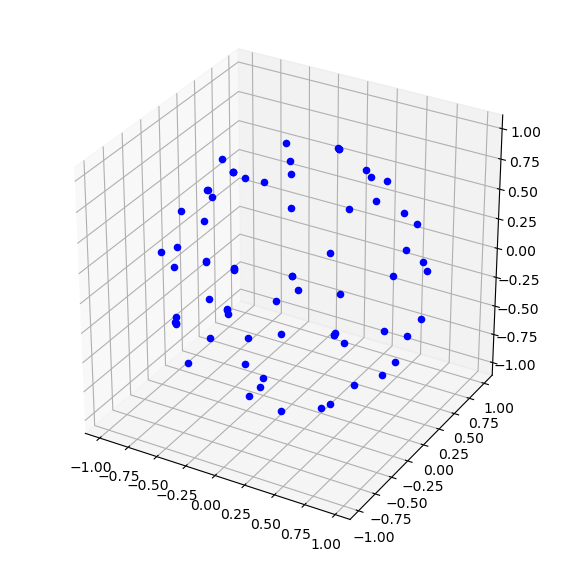

In [35]:
fig = plt.figure(figsize = (7, 7))
ax = plt.axes(projection ="3d")
for i in range(72):
    ax.scatter3D(vec[i][0], vec[i][1], vec[i][2], color ='b')